# Notebook 3: Creating, saving and reading radial profiles

This script shows how to

- make radial profiles and quickly plotting them
- save them as Paicos data
- create radial profiles for other particle types e.g. Dark Matter
- read the Paicos data file
- define a custom reader to conveniently read the data file
- plot the data from the file

Here we show how to create 1D histograms and save them using a `PaicosWriter` (which basically saves hdf5 files including the original meta data from the arepo snapshot and the units of whatever PaicosQuantity that you store).

The use case is here that we want to create radial profiles of various physical quantities. The actual plotting will take place in notebook 2b.

## Making a radial profile

#### Selecting a spherical region for analysis

First, we identify the center of the most massive FoF group in the simulation by accessing `GroupPos`. We retrieve the virial radius $R_{200,c}$. We find the indices of particles within the radial range from the center to r_max and create a new snapshot object that only contains the particles of interest. To do this, we use the `snap.select` method.

Finally, we calculate the radial distances of the selected particles from the center.

In [1]:
import paicos as pa
import numpy as np

# Open an Arepo snapshot
snap = pa.Snapshot(pa.data_dir, 247)

# The center of the most massive Friends-of-friends group in the simulation
center = snap.Cat.Group["GroupPos"][0]

R200c = snap.Cat.Group['Group_R_Crit200'][0]

# The maximum radius to be considered
r_max = 10000*center.uq
r_min = 1.e-2*r_max

# Use OpenMP parallel Cython code to find this central sphere
index = pa.util.get_index_of_radial_range(snap['0_Coordinates'],
                                          center, 0., r_max)

# Create a new snap object which only contains the index above
snap = snap.select(index, parttype=0)

# Calculate the radial distances (a bit duplicate here...)
r = np.sqrt(np.sum((snap["0_Coordinates"] - center[None, :]) ** 2.0,
            axis=1))

#### Computing the histogram and plotting it

We set up the binning, create a `Histogram` object using the radial distances and bins defined. We can choose to use a log scale for the bins.

We calculate the radial temperature profile using masses as a weight, convert this quantity to physical units and plot it.

Attempting to get derived variable: 0_TemperaturesTimesMasses...
	So we need the variable: 0_Temperatures...
	So we need the variable: 0_MeanMolecularWeight...	[DONE]



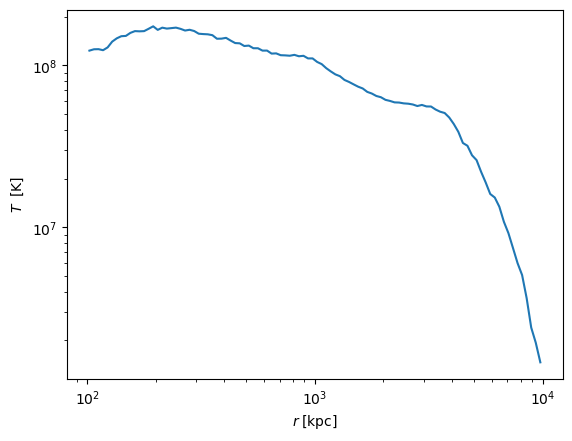

In [2]:

# Set up the binning
bins = [r_min, r_max, 100]

# Create a histogram object
h_r = pa.Histogram(r, bins=bins, logscale=True)

# Using mass as weight for temperature radial profile
r_temp_masses = h_r.hist(snap['0_TemperaturesTimesMasses'])
r_masses = h_r.hist(snap['0_Masses'])

r_temp = r_temp_masses/r_masses

# Convert to physical units
r_temp = r_temp.to_physical.to('K')
centers = h_r.bin_centers.to_physical.to('kpc')

import matplotlib.pyplot as plt
plt.plot(h_r.bin_centers, r_temp)
plt.ylabel(r_temp.label("T"))
plt.xlabel(centers.label("r"))
plt.xscale('log')
plt.yscale('log')


## Storing data


It is convenient to be able to store the data so that this step is de-coupled from the often many matplotlib iterations.

Below we illustrate how to save an PaicosData file, created using the  `PaicosWriter` class.

In [3]:
# Create a Paicos writer object
radfile = pa.PaicosWriter(snap, pa.data_dir, basename='radial')

# Save binning information
radfile.write_data('bin_centers', h_r.bin_centers)
radfile.write_data('r_min', r_min)
radfile.write_data('r_max', r_max)

# Save the bin volumes (of the shells)
bin_volumes = np.diff(4/3*np.pi*h_r.bin_edges**3)
radfile.write_data('bin_volumes', bin_volumes)


# Save various gas properties
gas_keys = ['0_Masses',
            '0_Volume',
            '0_TemperaturesTimesMasses',
            '0_MagneticFieldSquaredTimesVolume',
            '0_PressureTimesVolume']

# Do the histograms and save them at the same time
for key in gas_keys:
    radfile.write_data(key, h_r.hist(snap[key]))


Attempting to get derived variable: 0_Volume...	[DONE]

Attempting to get derived variable: 0_MagneticFieldSquaredTimesVolume...	[DONE]

Attempting to get derived variable: 0_PressureTimesVolume...	[DONE]



Save other useful information from the FoF catalog

In [5]:
# It will probably also be useful to have some group properties
# We save the 10 most massive FOF groups (sorted according to their M200_crit)
index = np.argsort(snap.Cat.Group['Group_M_Crit200'])[::-1]
for key in snap.Cat.Group.keys():
    radfile.write_data(key, snap.Cat.Group[key][index[:10]], group='Group')

# Short hand access to the most massive will probably be nice
radfile.write_data('R200c', R200c)
radfile.write_data('center', center)


### Making mass histograms for non-gas particles

Let's also use data from non-gas particles to make mass histograms, and save them to the file.

In [4]:
# Let us now also add some other parttype profiles
for parttype in range(1, snap.nspecies):
    pstr = '{}_'.format(parttype)
    # Re-open the Arepo snapshot
    snap = pa.Snapshot(pa.data_dir, 247)

    # Use OpenMP parallel Cython code to find this central sphere
    index = pa.util.get_index_of_radial_range(snap[pstr+'Coordinates'],
                                              center, 0., r_max)

    # Create a new snap object which only contains the index above
    snap = snap.select(index, parttype=parttype)

    r = np.sqrt(np.sum((snap[pstr+"Coordinates"] - center[None, :]) ** 2.0,
                axis=1))

    # Create a new histogram object
    h_r = pa.Histogram(r, bins=bins, logscale=True)

    # Compute the mass profile for other particle types
    h_r.hist(snap[pstr + 'Masses'])
    radfile.write_data(pstr + 'Masses', h_r.hist(snap[pstr + 'Masses']))


Attempting to get derived variable: 1_Masses...	[DONE]

Attempting to get derived variable: 3_Masses...	[DONE]



We can now close the file

In [6]:
# Finally, close the file
# Rename from a tmp_*.hdf5 file to the final filename
radfile.finalize()
print(radfile.tmp_filename)
print(radfile.filename)

/home/lena/analysis/paicos/data/tmp_radial_247.hdf5
/home/lena/analysis/paicos/data/radial_247.hdf5


## Reading data

Now let's open this file and look at its contents. We can use the `PaicosReader` class which is made to read saved data including units and metadata.

In [7]:
# Simply read the radial file using the standard reader
pro_simple = pa.PaicosReader(pa.data_dir, 247,
                             basename='radial', load_all=True)

In [8]:
# The data fields that have been loaded
pro_simple.keys()

dict_keys(['0_MagneticFieldSquaredTimesVolume', '0_Masses', '0_PressureTimesVolume', '0_TemperaturesTimesMasses', '0_Volume', '1_Masses', '2_Masses', '3_Masses', '4_Masses', '5_Masses', 'Group', 'R200c', 'bin_centers', 'bin_volumes', 'center', 'r_max', 'r_min', 'org_info'])

In [9]:
# They all have units, for instance
pro_simple['0_PressureTimesVolume'][1].to('erg')

<PaicosQuantity 1.68020224e+61 erg / small_h>

The `PaicosReader` object has many of the same attributes as an instance of the Snapshot class (see Notebook 1) e.g. you can access

In [18]:
pro_simple.Config
pro_simple.Header
pro_simple.Parameters
pro_simple.age

<PaicosQuantity 13.80223476 Gyr>

This is because the Snapshot class is a subclass of the PaicosReader class. 

## Define a custom reader

The default reader is already quite useful. It can however also be useful to define custom readers as done below.

In [13]:
class RadialReader(pa.PaicosReader):
    """
    A quick custom reader for radial profiles.
    This reader gets the densities and the weighted variables of interest
    """
    def __init__(self, basedir, snapnum, basename="radial", load_all=True):

        # The PaicosReader class takes care of most of the loading
        super().__init__(basedir, snapnum, basename=basename,
                         load_all=load_all)

        # Get the interesting profiles
        keys = list(self.keys())

        for key in keys:
            if 'Times' in key:
                # Keys of the form 'MagneticFieldSquaredTimesVolume'
                # are split up
                start, end = key.split('Times')
                if (end in keys):
                    self[start] = self[key]/self[end]
                    del self[key]
                elif (start[0:2] + end in keys):
                    self[start] = self[key]/self[start[0:2] + end]
                    del self[key]

        # Calculate density if we have both masses and volumes
        for p in ['', '0_']:
            if (p + 'Masses' in keys) and (p + 'Volume' in keys):
                self[p + 'Density'] = self[p+'Masses']/self[p+'Volume']

        # For dark matter we use the bin volumes
        for p in [str(i) + '_' for i in range(1, 5)]:
            self[p + 'Density'] = self[p+'Masses']/self['bin_volumes']
            del self[p+'Masses']

# Use the reader
pro = RadialReader(pa.data_dir, 247)

In [11]:
# The data fields now contain the following fields
pro.keys()

dict_keys(['0_Masses', '0_Volume', '5_Masses', 'Group', 'R200c', 'bin_centers', 'bin_volumes', 'center', 'r_max', 'r_min', 'org_info', '0_MagneticFieldSquared', '0_Pressure', '0_Temperatures', '0_Density', '1_Density', '2_Density', '3_Density', '4_Density'])

## Plotting the radial profiles and dealing with units

Let's make a density plot of the different particle types.

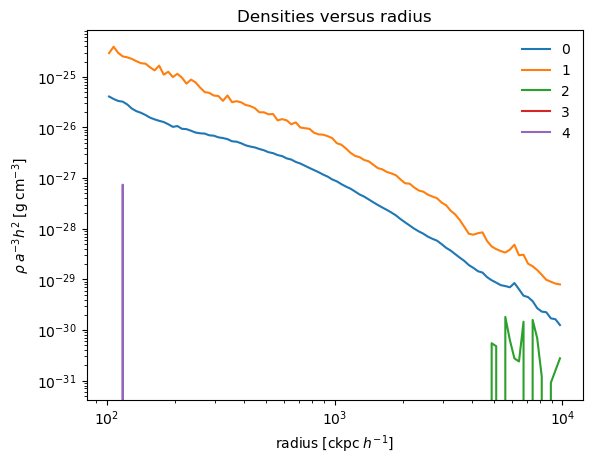

In [16]:
# Make a density plot of the varius particle types
import matplotlib.pyplot as plt
for p in range(5):
    pstr = str(p)
    plt.loglog(pro['bin_centers'].astro, pro[pstr + '_Density'].cgs, label=pstr)

plt.xlabel(pro['bin_centers'].astro.label(r'\mathrm{radius}'))
plt.ylabel(pro['0_Density'].cgs.label(r'\rho'))
plt.title('Densities versus radius')
plt.legend(frameon=False)

In the plot above we have not dealt with unit conversions. We do this below:

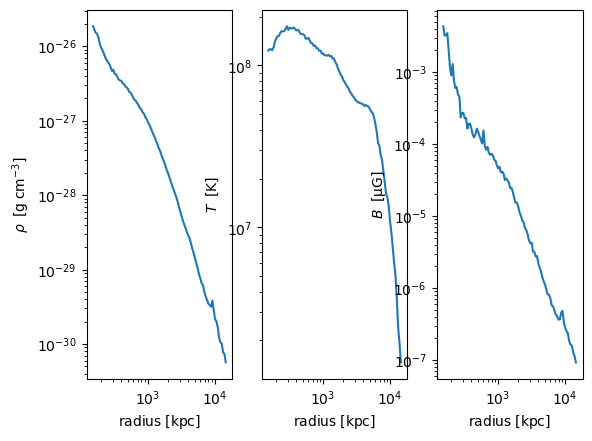

In [17]:
# Plot gas properties
fig, axes = plt.subplots(num=2, ncols=3, sharex=True)

# Unit conversions
centers = pro['bin_centers'].astro.to_physical
rho = pro['0_Density'].cgs.to_physical
B = np.sqrt(pro['0_MagneticFieldSquared']).to('uG').to_physical

# Plotting
axes[0].loglog(centers, rho)
axes[0].set_ylabel(rho.label("\\rho"))

axes[1].loglog(centers, pro['0_Temperatures'])
axes[1].set_ylabel(pro['0_Temperatures'].label("T"))

axes[2].loglog(centers, B)
axes[2].set_ylabel(B.label("B"))

for ii in range(3):
    axes[ii].set_xlabel(centers.label(r'\mathrm{radius}'))

Let's plot the group properties

Text(0, 0.5, '$M_{200\\mathrm{c}}\\;\\; \\left[\\mathrm{M_{\\odot}}\\right]$')

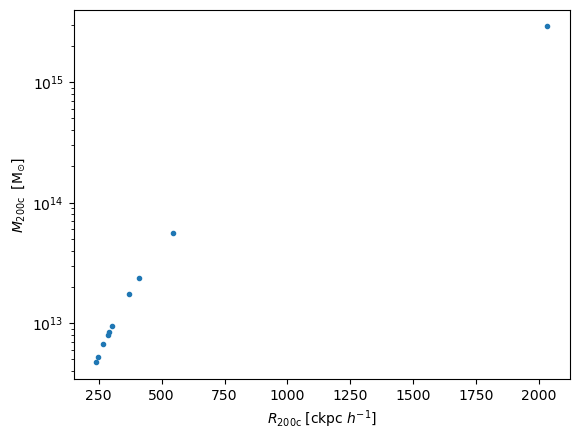

In [18]:
# Plot halo masses versus radii
R = pro['Group']['Group_R_Crit200'].astro
M = pro['Group']['Group_M_Crit200'].no_small_h.astro
plt.semilogy(R, M, '.')
plt.xlabel(R.label(r'R_{200\mathrm{c}}'))
plt.ylabel(M.label(r'M_{200\mathrm{c}}'))